# Evaluación técnica de candidatos - Científico de datos
## Objetivo:
Modela un clasificador sencillo en Python o R para  identificar el tipo de defecto que presenta el planchón.
## Datos de entrada: 
1. Un archivo TRAIN en formato tabla con 27 atributos/variables independientes, 7 clases/ variables dependientes y 1455 observaciones.
Las clases: 
* Pastry
* Z_Scratch
* K_Scatch
* Stains
* Dirtiness
* Bumps
* Other_Faults, 
son defectos que se encuentran en los planchones de acero. 
2. Un archivo TEST en formato tabla con  27 atributos/variables y 485 observaciones sobre las que se hará la clasificación de las variables faltantes. 

## Entregable: 
1. El archivo en formato tabla, con las clases concatenadas al final del archivo, siguiendo el formato del archivo TRAIN.
2. El código en R o Python con el que se obtuvo la clasificación, debidamente comentado. 
3. Adicionalmente, se pueden entregar visualizaciones del set de datos y de la solución propuesta, así como su justificación. 


```
"Fallas en planchones de acero"

Elaborado por Sandra de la Fuente
2021-08-21
Dudas: contacto@sandradelafuente.com
```



# Lectura y visualización de datos

In [1]:
######################################
#Carga de dataframe al cuadernillo
#Los archivos fueron cargados previamente a Google Drive en correo personal con la dirección 'My Drive/Colab Notebooks/Tecnoap/Evaluacion'
from google.colab import drive #La autenticación de la cuenta de google drive es necesaria. Para mayor información, consulte https://colab.research.google.com/notebooks/io.ipynb
drive.mount('/content/drive') #Se monta la carpeta raíz de Google Drive al cuadernillo de trabajo.
!cp "/content/drive/My Drive/Colab Notebooks/Tecnoap/Evaluacion/Faults.train" "Faults.train" #Se carga una copia del archivo "Faults.train" al espacio de trabajo.
!cp "/content/drive/My Drive/Colab Notebooks/Tecnoap/Evaluacion/Faults.test" "Faults.test" #Se carga una copia del archivo "Faults.test" al espacio de trabajo.
#######################################

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings #Se importa la librería de notificaciones
warnings.filterwarnings('ignore') #Se omiten las notificaciones no relevantes en el código para hacer más amigable el código.
import rpy2.robjects as robjects #Se carga la paquetería de R para trabajar en R desde el entorno de Python 3, para este ejemplo.
%load_ext rpy2.ipython 

#Esta extensión nos permitirá establecer si queremos lenguaje R en la línea de código como "%%R"

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
gpu()

<tf.Tensor: shape=(), dtype=float32, numpy=1732.2793>

In [4]:
%%R 
# %%R <- Lenguaje de la línea de código: R 
pkgs_Sec1 <- c('rsample', 'tidyverse', 'patchwork','caret', 'skimr')
install.packages(pkgs_Sec1)
library(rsample) 
library(tidyverse)
library(patchwork)
library(ggplot2)
library(caret)
library(skimr)

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/rsample_0.1.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 280155 bytes (273 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

In [5]:
%%R 
# %%R <- Lenguaje de la línea de código: R
#Datos de entrenamiento
Faults_train <- read.table("Faults.train")
dim(Faults_train) #Se verifica que la información de entrenamiento se cargó adecuadamente. Las dimensiones del arreglo es de 1456 x 35
head(Faults_train) #Se considerará la fila 1 como header de la tabla en la línea siguiente porque actualmente se tiene otra información. Este cambio nos permitirá visualizar los datos con las leyendas adecuadas.
#Datos de prueba
Faults_test <- read.table("Faults.test")
dim(Faults_test)  #Se verifica que la información de entrenamiento se cargó adecuadamente. Las dimensiones del arreglo es de 486 x 28
head(Faults_test) #Se considerará la fila 1 como header de la tabla en la línea siguiente porque actualmente se tiene otra información. Este cambio nos permitirá visualizar los datos con las leyendas adecuadas.

  V1        V2        V3        V4        V5           V6          V7
1 NA X_Minimum X_Maximum Y_Minimum Y_Maximum Pixels_Areas X_Perimeter
2  2       829       835   1553913   1553931           71           8
3  4      1289      1306    498078    498335         2409          60
4  6       413       446    138468    138883         9052         230
5  9        74        90    779144    779308         1506          46
6 12        46        58    179258    179312          480          15
           V8                V9                   V10                   V11
1 Y_Perimeter Sum_of_Luminosity Minimum_of_Luminosity Maximum_of_Luminosity
2          19              7972                    99                   125
3         260            246930                    37                   126
4         432           1481991                    23                   199
5         167            180215                    53                   143
6          54             61966                   102 

In [6]:
%%R 
names(Faults_train) <- as.matrix(Faults_train[1, ]) #Se nombra los encabezados de cada columna de la tabla de entrenamiento con la etiqueta de la fila 1.
Faults_train <- Faults_train[-1, ] #Se elimina la fila 1 de la tabla (pues corresponde a las etiquetas que ahora están en los encabezados).
Faults_train <- Faults_train[,-1] #Se elimina la columna 1 de la tabla (pues corresponde al número de fila).
Faults_train[] <- lapply(Faults_train, function(x) type.convert(as.character(x))) #Convierte las variables en caracteres.
head(Faults_train) #Muesta las primeras filas de la tabla de entrenamiento.

names(Faults_test) <- as.matrix(Faults_test[1, ])  #Se nombra los encabezados de cada columna de la tabla de entrenamiento con la etiqueta de la fila 1.
Faults_test <- Faults_test[-1, ] #Se elimina la fila 1 de la tabla (pues corresponde a las etiquetas que ahora están en los encabezados).
Faults_test <- Faults_test[,-1 ] #Se elimina la columna 1 de la tabla (pues corresponde al número de fila).
Faults_test[] <- lapply(Faults_test, function(x) type.convert(as.character(x))) #Convierte las variables en caracteres.
head(Faults_test)  #Muesta las primeras filas de la tabla de prueba.

  X_Minimum X_Maximum Y_Minimum Y_Maximum Pixels_Areas X_Perimeter Y_Perimeter
2       829       835   1553913   1553931           71           8          19
3      1289      1306    498078    498335         2409          60         260
4       413       446    138468    138883         9052         230         432
5        74        90    779144    779308         1506          46         167
6        46        58    179258    179312          480          15          54
7        82        89    844704    844729          137           8          25
  Sum_of_Luminosity Minimum_of_Luminosity Maximum_of_Luminosity
2              7972                    99                   125
3            246930                    37                   126
4           1481991                    23                   199
5            180215                    53                   143
6             61966                   102                   158
7             14907                    92                   126

In [7]:
%%R 
colnames(Faults_train) #Se muestra el nombre de las columnas de la tabla de entrenamiento.

 [1] "X_Minimum"             "X_Maximum"             "Y_Minimum"            
 [4] "Y_Maximum"             "Pixels_Areas"          "X_Perimeter"          
 [7] "Y_Perimeter"           "Sum_of_Luminosity"     "Minimum_of_Luminosity"
[10] "Maximum_of_Luminosity" "Length_of_Conveyer"    "TypeOfSteel_A300"     
[13] "TypeOfSteel_A400"      "Steel_Plate_Thickness" "Edges_Index"          
[16] "Empty_Index"           "Square_Index"          "Outside_X_Index"      
[19] "Edges_X_Index"         "Edges_Y_Index"         "Outside_Global_Index" 
[22] "LogOfAreas"            "Log_X_Index"           "Log_Y_Index"          
[25] "Orientation_Index"     "Luminosity_Index"      "SigmoidOfAreas"       
[28] "Pastry"                "Z_Scratch"             "K_Scatch"             
[31] "Stains"                "Dirtiness"             "Bumps"                
[34] "Other_Faults"         


In [8]:
%%R
var_train <- as.data.frame.matrix(Faults_train[,-(28:34)]) #Adaptamos la tabla "Variables de entrada" como "var_train" 
class_train <- as.data.frame.matrix(Faults_train[,-(1:27)]) #Adaptamos la tabla de clases como "class_train"
summary(class_train)

     Pastry         Z_Scratch          K_Scatch          Stains       
 Min.   :0.0000   Min.   :0.00000   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.:0.00000  
 Median :0.0000   Median :0.00000   Median :0.0000   Median :0.00000  
 Mean   :0.0811   Mean   :0.09966   Mean   :0.2021   Mean   :0.03711  
 3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:0.0000   3rd Qu.:0.00000  
 Max.   :1.0000   Max.   :1.00000   Max.   :1.0000   Max.   :1.00000  
   Dirtiness           Bumps         Other_Faults   
 Min.   :0.00000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.00000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.00000   Median :0.0000   Median :0.0000  
 Mean   :0.02887   Mean   :0.2076   Mean   :0.3436  
 3rd Qu.:0.00000   3rd Qu.:0.0000   3rd Qu.:1.0000  
 Max.   :1.00000   Max.   :1.0000   Max.   :1.0000  


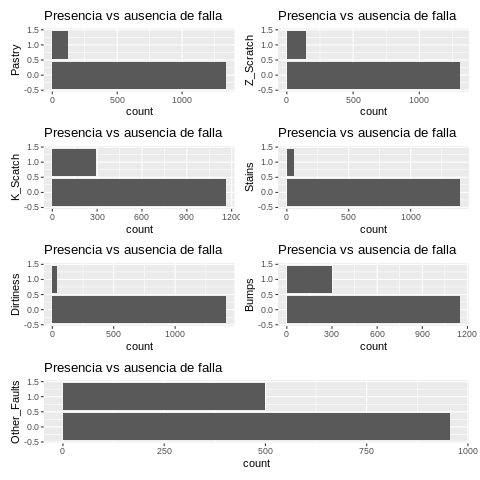

In [9]:
%%R
# Se grafica cada clase para mostrar el número de eventos con fallas detectadas en el experimento 
g0 <- ggplot(class_train, aes(y=Pastry)) + geom_bar() + labs(title = "Presencia vs ausencia de falla")  
g1 <- ggplot(class_train, aes(y=Z_Scratch)) + geom_bar() + labs(title = "Presencia vs ausencia de falla") 
g2 <- ggplot(class_train, aes(y=K_Scatch)) + geom_bar() + labs(title = "Presencia vs ausencia de falla") 
g3 <- ggplot(class_train, aes(y=Stains)) + geom_bar() + labs(title = "Presencia vs ausencia de falla") 
g4 <- ggplot(class_train, aes(y=Dirtiness)) + geom_bar()+ labs(title = "Presencia vs ausencia de falla") 
g5 <- ggplot(class_train, aes(y=Bumps)) + geom_bar() + labs(title = "Presencia vs ausencia de falla") 
g6 <- ggplot(class_train, aes(y=Other_Faults)) + geom_bar()+ labs(title = "Presencia vs ausencia de falla") 

(g0 | g1) / (g2 |g3 )/(g4 | g5) /
g6 #Exhibición y acomodo de gráficas

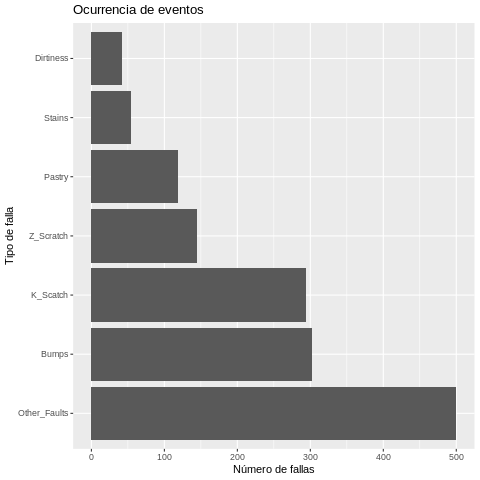

In [10]:
%%R
# Se grafica de forma ordenada el número de eventos presentes en la muestra, por cada clase. 
df <- data.frame(class_train)
df %>%
    gather(season,count) %>%
    filter(count > 0) %>%
    ggplot(aes(forcats::fct_infreq(season))) +
        geom_bar() + coord_flip() + labs(title = "Ocurrencia de eventos", x = "Tipo de falla", y = "Número de fallas")

In [11]:
%%R
# Impresión del nombres de las variables
names(Faults_test)

 [1] "X_Minimum"             "X_Maximum"             "Y_Minimum"            
 [4] "Y_Maximum"             "Pixels_Areas"          "X_Perimeter"          
 [7] "Y_Perimeter"           "Sum_of_Luminosity"     "Minimum_of_Luminosity"
[10] "Maximum_of_Luminosity" "Length_of_Conveyer"    "TypeOfSteel_A300"     
[13] "TypeOfSteel_A400"      "Steel_Plate_Thickness" "Edges_Index"          
[16] "Empty_Index"           "Square_Index"          "Outside_X_Index"      
[19] "Edges_X_Index"         "Edges_Y_Index"         "Outside_Global_Index" 
[22] "LogOfAreas"            "Log_X_Index"           "Log_Y_Index"          
[25] "Orientation_Index"     "Luminosity_Index"      "SigmoidOfAreas"       


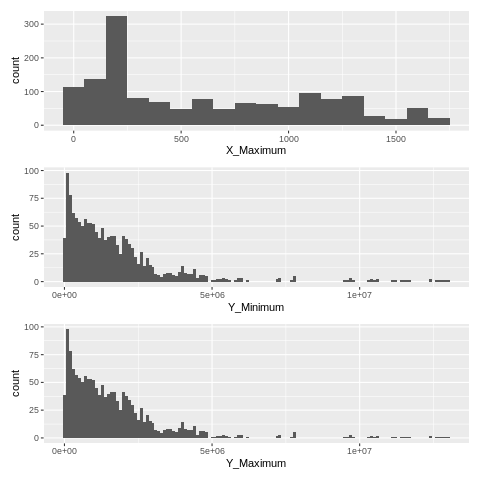

In [12]:
%%R
#Histograma
#En las siguientes líneas de código, se grafican los histogramas de las variables para identificar oportunidades de mejora en el preprocesamiento de los datos.
q1 <-  ggplot(Faults_train, aes(X_Maximum)) +
  geom_histogram(binwidth = 100)
q2 <-  ggplot(Faults_train, aes(Y_Minimum)) +
  geom_histogram(binwidth = 100000)
q3 <-  ggplot(Faults_train, aes(Y_Maximum)) +
  geom_histogram(binwidth = 100000)

q1 / q2 / q3

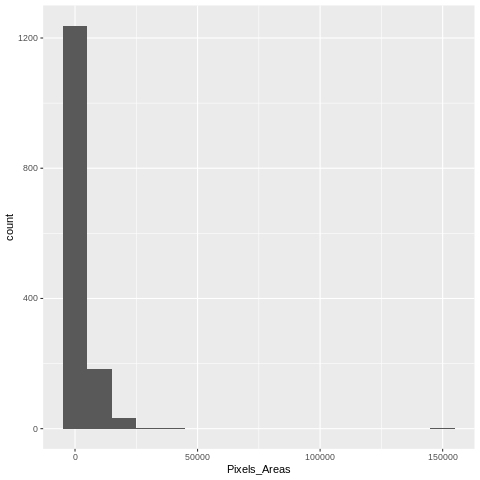

In [13]:
%%R
q4 <- ggplot(Faults_train, aes(Pixels_Areas)) +
  geom_histogram(binwidth = 10000)
q4

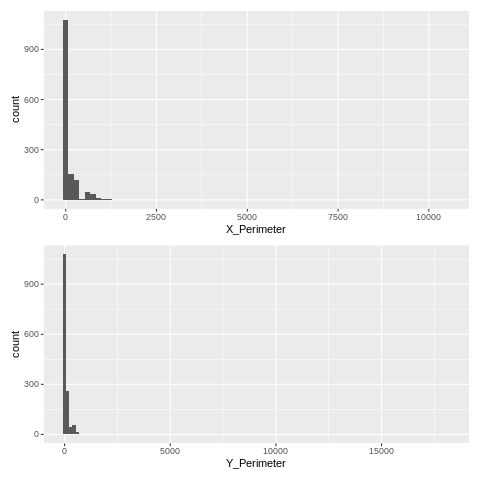

In [14]:
%%R
q5 <- ggplot(Faults_train, aes(X_Perimeter)) +
  geom_histogram(binwidth = 150)
q6 <- ggplot(Faults_train, aes(Y_Perimeter)) +
  geom_histogram(binwidth = 150)
q5 / q6

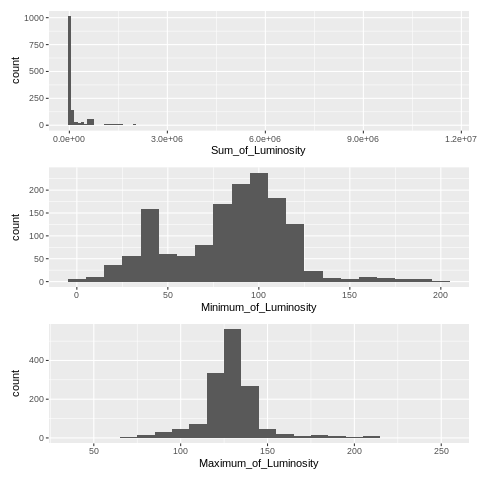

In [15]:
%%R
q7 <- ggplot(Faults_train, aes(Sum_of_Luminosity)) +
  geom_histogram(binwidth = 100000)
q8 <- ggplot(Faults_train, aes(Minimum_of_Luminosity)) +
  geom_histogram(binwidth = 10)
q9 <- ggplot(Faults_train, aes(Maximum_of_Luminosity)) +
  geom_histogram(binwidth = 10)
q7/q8/q9

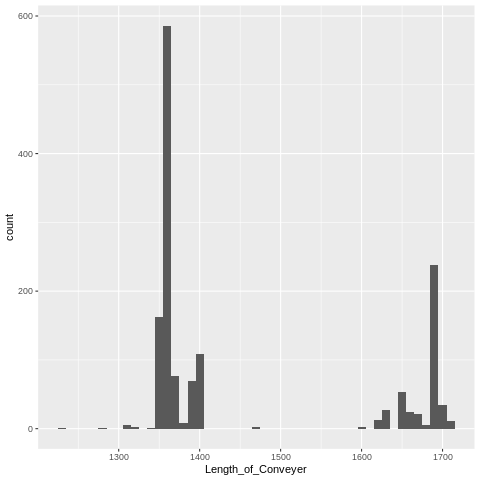

In [16]:
%%R
q10 <- ggplot(Faults_train, aes(Length_of_Conveyer)) +
  geom_histogram(binwidth = 10)
q10

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



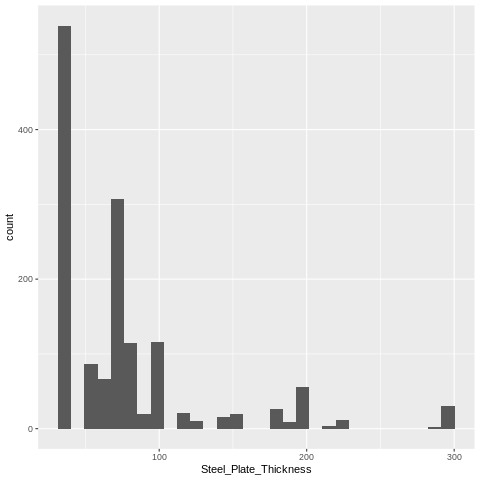

In [17]:
%%R
q11 <- ggplot(Faults_train, aes(Steel_Plate_Thickness)) +
  geom_histogram()
q11

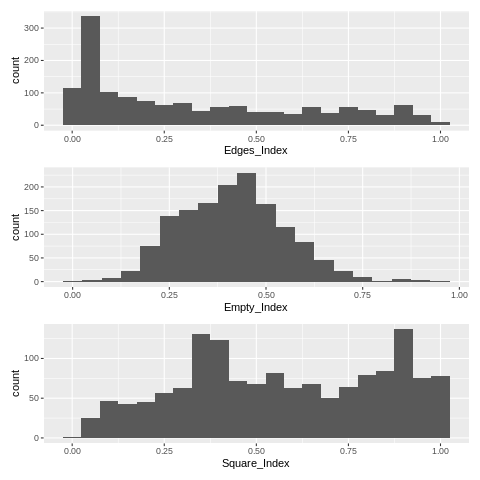

In [18]:
%%R
q12 <- ggplot(Faults_train, aes(Edges_Index)) +
  geom_histogram(binwidth = 0.05)
q13 <- ggplot(Faults_train, aes(Empty_Index)) +
  geom_histogram(binwidth = 0.05)
q14 <- ggplot(Faults_train, aes(Square_Index)) +
  geom_histogram(binwidth = 0.05)
q12/q13/q14

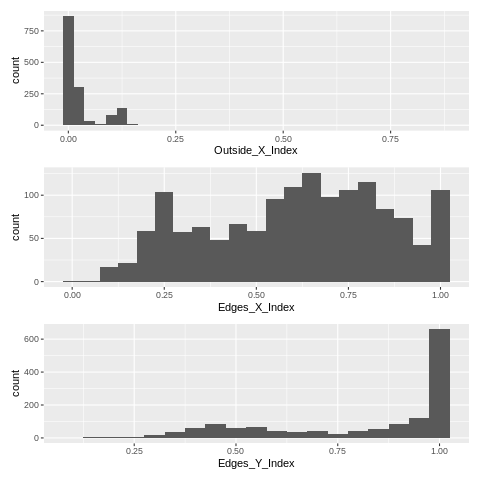

In [19]:
%%R
q15 <- ggplot(Faults_train, aes(Outside_X_Index)) +
  geom_histogram(binwidth = 0.025)
q16 <- ggplot(Faults_train, aes(Edges_X_Index)) +
  geom_histogram(binwidth = 0.05)
q17 <- ggplot(Faults_train, aes(Edges_Y_Index)) +
  geom_histogram(binwidth = 0.05)
q15/q16/q17

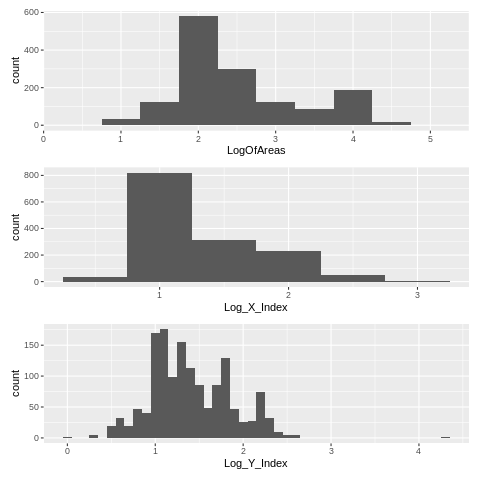

In [20]:
%%R
q18 <- ggplot(Faults_train, aes(LogOfAreas)) +
  geom_histogram(binwidth = 0.5)
q19 <- ggplot(Faults_train, aes(Log_X_Index)) +
  geom_histogram(binwidth = 0.5)
q20 <- ggplot(Faults_train, aes(Log_Y_Index)) +
  geom_histogram(binwidth = .1)
q18/q19/q20

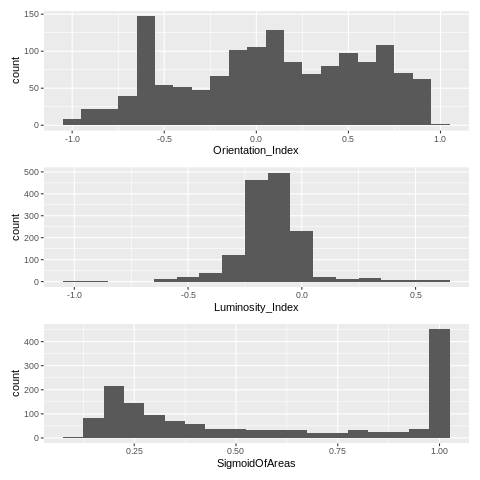

In [21]:
%%R
q21 <- ggplot(Faults_train, aes(Orientation_Index)) +
  geom_histogram(binwidth = 0.1)
q22 <- ggplot(Faults_train, aes(Luminosity_Index)) +
  geom_histogram(binwidth = 0.1)
q23 <- ggplot(Faults_train, aes(SigmoidOfAreas)) +
  geom_histogram(binwidth = 0.05)
q21/q22/q23

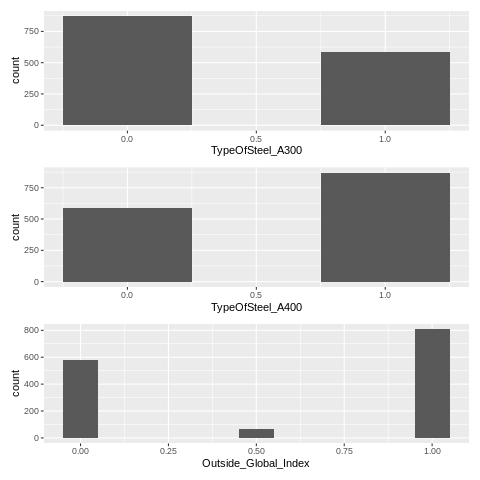

In [22]:
%%R
q24 <- ggplot(Faults_train, aes(TypeOfSteel_A300)) +
  geom_histogram(binwidth = 0.5)
q25 <- ggplot(Faults_train, aes(TypeOfSteel_A400)) +
  geom_histogram(binwidth = 0.5)
q26 <- ggplot(Faults_train, aes(Outside_Global_Index)) +
  geom_histogram(binwidth = 0.1)
q24/q25/q26

## Preparando los datos

In [23]:
%%R
#Debido a que se mostró una amplia variación en las escalas de las variables, escalaremos los valores y revisaremos el resultado resumido 
skimmed <- skim_to_wide(var_train)
skimmed

── Data Summary ────────────────────────
                           Values
Name                       .data 
Number of rows             1455  
Number of columns          27    
_______________________          
Column type frequency:           
  numeric                  27    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable         n_missing complete_rate         mean           sd
 1 X_Minimum                     0             1     570.         517.    
 2 X_Maximum                     0             1     616.         494.    
 3 Y_Minimum                     0             1 1676894.     1826262.    
 4 Y_Maximum                     0             1 1676950.     1826278.    
 5 Pixels_Areas                  0             1    1908.        5541.    
 6 X_Perimeter                   0             1     114.         331.    
 7 Y_Perimeter                   0            

In [24]:
%%R
#Nuestras variables escaladas nos ayudarán a que el modelo sea más exacto.
scale <- preProcess(var_train, method='scale')
scaled_var_train <- predict(scale, newdata = var_train)
skimmed_transformed <- skim_to_wide(scaled_var_train)
skimmed_transformed

── Data Summary ────────────────────────
                           Values
Name                       .data 
Number of rows             1455  
Number of columns          27    
_______________________          
Column type frequency:           
  numeric                  27    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable         n_missing complete_rate   mean    sd        p0     p25
 1 X_Minimum                     0             1  1.10      1  0         0.108 
 2 X_Maximum                     0             1  1.25      1  0.00810   0.393 
 3 Y_Minimum                     0             1  0.918     1  0.00368   0.275 
 4 Y_Maximum                     0             1  0.918     1  0.00368   0.275 
 5 Pixels_Areas                  0             1  0.344     1  0.000361  0.0149
 6 X_Perimeter                   0             1  0.343     1  0.00604   0.0453
 7 Y_Perime

In [25]:
%%R
train_db <- as.data.frame.matrix(Faults_train) 
train_db <- train_db %>% add_column(Fault = 0)
train_db$Fault[which(train_db$Pastry == 1)] = "Pastry"
train_db$Fault[which(train_db$Z_Scratch == 1)] = "Z_Scratch"
train_db$Fault[which(train_db$K_Scatch == 1)] = "K_Scatch"
train_db$Fault[which(train_db$Stains == 1)] = "Stains"
train_db$Fault[which(train_db$Dirtiness == 1)] = "Dirtiness"
train_db$Fault[which(train_db$Bumps == 1)] = "Bumps"
train_db$Fault[which(train_db$Other_Faults == 1)] = "Other"

head(train_db)

  X_Minimum X_Maximum Y_Minimum Y_Maximum Pixels_Areas X_Perimeter Y_Perimeter
2      1343      1351     46714     46725           56          11          11
3       354       370    409908    409918          116          19          10
4      1056      1077   4364066   4364076          106          35          22
5       816       822    899659    899665           18           8           6
6        78        94   1523381   1523431          463          69          54
7       618       650   2017425   2017438          103          51          20
  Sum_of_Luminosity Minimum_of_Luminosity Maximum_of_Luminosity
2              5729                    90                   117
3             12174                    82                   126
4             10747                    89                   116
5              2384                   127                   141
6             60518                   118                   141
7             13657                   124                   141

In [26]:
%%R
#Prepara los datos

library(recipes)

receta <- train_db %>% 
recipe(Fault ~ .) %>% #Definimos "Fault" como nuestra variable dependiente
step_rm(Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults) %>% #Elimina las columnas de las variables independientes, pues la información que ocuparemos está en la variable "Fault".
step_dummy(all_nominal(), -all_outcomes()) %>% #Para variables categóricas independientes, únicamente.
step_scale(all_predictors(), -all_outcomes()) %>% #Escala las variables de entrada como en el ejemplo anterior, visualizado con skimr. Sólamente funciona para las variables independientes.
prep()

save(receta, file = "receta.RData") #Guarda la receta 

variables <- summary(receta) #Muestra el tipo de variable, rol y origen en la receta
variables[20:28,] #Selecciona las filas a mostrar
#Puede notar que nuestro groundtruth es la variable "Fault" y las demás variables independientes. 
#Los datos en este punto, ya se encuentran ordenados y listos para ser utilizados en el modelo.

R[write to console]: 
Attaching package: ‘recipes’


R[write to console]: The following object is masked from ‘package:stringr’:

    fixed


R[write to console]: The following object is masked from ‘package:stats’:

    step




# A tibble: 9 × 4
  variable             type    role      source  
  <chr>                <chr>   <chr>     <chr>   
1 Edges_Y_Index        numeric predictor original
2 Outside_Global_Index numeric predictor original
3 LogOfAreas           numeric predictor original
4 Log_X_Index          numeric predictor original
5 Log_Y_Index          numeric predictor original
6 Orientation_Index    numeric predictor original
7 Luminosity_Index     numeric predictor original
8 SigmoidOfAreas       numeric predictor original
9 Fault                nominal outcome   original


In [27]:
%%R
#Se extrae la muestra de entrenamiento de la receta
x_train_db <- receta %>%
juice(all_predictors(),
composition = "matrix")
y_train_db <- receta %>%
juice(all_outcomes()) %>%
pull()

In [28]:
%%R
summary(Faults_test)

   X_Minimum        X_Maximum        Y_Minimum          Y_Maximum       
 Min.   :   0.0   Min.   :   8.0   Min.   :    7851   Min.   :    7865  
 1st Qu.:  49.0   1st Qu.: 190.0   1st Qu.:  407114   1st Qu.:  407124  
 Median : 445.0   Median : 478.0   Median : 1116225   Median : 1116232  
 Mean   : 575.5   Mean   : 624.1   Mean   : 1574903   Mean   : 1574949  
 3rd Qu.:1061.0   3rd Qu.:1080.0   3rd Qu.: 2183073   3rd Qu.: 2183084  
 Max.   :1687.0   Max.   :1696.0   Max.   :10440356   Max.   :10440367  
  Pixels_Areas    X_Perimeter      Y_Perimeter    Sum_of_Luminosity
 Min.   :    9   Min.   :   4.0   Min.   :  2.0   Min.   :   1063  
 1st Qu.:   89   1st Qu.:  15.0   1st Qu.: 14.0   1st Qu.:  10329  
 Median :  175   Median :  28.0   Median : 25.0   Median :  19650  
 Mean   : 1855   Mean   : 106.7   Mean   : 74.2   Mean   : 204758  
 3rd Qu.:  935   3rd Qu.:  90.0   3rd Qu.: 89.0   3rd Qu.:  95390  
 Max.   :25323   Max.   :1084.0   Max.   :680.0   Max.   :3037459  
 Minimum_of_L

In [29]:
%%R
#Se procesa la información para la prueba
Faults_test <- Faults_test %>% add_column(Fault = 0)
baked_test <- bake(receta, Faults_test)
x_test_db <- baked_test %>%
select(-Fault) %>%
as.matrix()
y_vec_test <- baked_test %>%
select(Fault) %>%
pull()

In [30]:
%%R
#Se muestra la información de las variables en la base de datos de prueba
skim_to_wide(baked_test)

── Data Summary ────────────────────────
                           Values
Name                       .data 
Number of rows             485   
Number of columns          28    
_______________________          
Column type frequency:           
  factor                   1     
  numeric                  27    
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 Fault               485             0 FALSE          0
  top_counts                    
1 Bum: 0, Dir: 0, K_S: 0, Oth: 0

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable         n_missing complete_rate   mean    sd       p0     p25
 1 X_Minimum                     0             1  1.11  1.03   0        0.0948
 2 X_Maximum                     0             1  1.26  1.03   0.0162   0.385 
 3 Y_Minimum                     0    

## Entrenamiento del modelo de clasificación.

In [32]:
%%R

install.packages(“devtools”)
library(devtools)
install.packages(“reticulate”)
library(reticulate)
install_github(“rstudio/keras”) 
library(keras)
install_keras(tensorflow = “gpu”)
reticulate::py_config() 
reticulate::py_module_available(“keras”)

#install.packages("keras")
library(keras)
#library(tidyverse)

RParsingError: ignored

In [ ]:
%%R
#Empleando la librería Keras, se procesa el modelo
model <- keras_model_sequential() %>%
  layer_dense(
    units = 27, 
    kernel_initializer = "uniform", 
    activation = "relu", 
    input_shape = ncol(x_train_db)) %>% 
  layer_dropout(rate = 0.1) %>%
  layer_dense(
    units = 16, 
    kernel_initializer = "uniform", 
    activation = "relu") %>% 
  layer_dropout(rate = 0.1) %>%
  layer_dense(
    units = 1, 
    kernel_initializer = "uniform", 
    activation = "sigmoid") %>% 
  compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = c('accuracy')
  )

model_keras

In [ ]:
%%R
history <- fit(
  object = model, 
  x = x_train_db, 
  y = y_train_db,
  batch_size = 50, 
  epochs = 35,
  validation_split = 0.30,
  verbose = 0
)

In [ ]:
%%R
print(history)

In [ ]:
%%R
theme_set(theme_bw())
plot(history) 

# Conclusiones

Como se muestra en la gráfica 1, es más común que no se presenten fallas. Sin embargo, se recomienda identificar las causas de mayor interés **Bumps**, **K_Scatch** y **Otras fallas** por la itinerancia de eventos, como se muestra en la gráfica 2.